# Tentative de Clusterisation des communes situées dans un périmètre de rayon 140km autour de Lyon

## 1 - Chargement du jeu des données fusionnées hors salaire (geoloc, population, entreprises, consommation) master.csv et filtrage sur Lyon et périmètre 80km

## 2 Pré-traitement des données pour séparer les variables catégorielles des variables quanti

## 3 - Traitement des données en vue d'une Analyse des Composantes principales (PCA

## 4 - Mise en oeuvre de Kmeans pour créer un nombres adaptés de Clusters

## 5 - Intégration du Cluster déterminé pour chaque commune, et positionnement sur une carte pour visualiser comment les clusters sont répartis géographiquement

## Partie 1 - Chargement du jeux de données master.csv et packages nécessaires

In [129]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# pour le pre processing
from utils import spherical_dist
from utils import transform_into_bins
from sklearn.preprocessing import MinMaxScaler

# pour PCA 
from sklearn.decomposition import PCA

# pour le Clustering
from sklearn.cluster import KMeans



In [105]:
df = pd.read_csv('clean_data/master.csv')

df.head()


,numero_departement,nom_commune,code_region,nom_region,codgeo,latitude,longitude,libgeo_x,nb_ent,nb_ent_0,...,nombre_de_points_libelle_grand_secteur_agriculture,consommation_libelle_grand_secteur_agriculture,nombre_de_points_libelle_grand_secteur_industrie,consommation_libelle_grand_secteur_industrie,nombre_de_points_libelle_grand_secteur_secteur inconnu,consommation_libelle_grand_secteur_secteur inconnu,nombre_de_points_libelle_grand_secteur_tertiaire,consommation_libelle_grand_secteur_tertiaire,nombre_de_points_libelle_grand_secteur_résidentiel,consommation_libelle_grand_secteur_résidentiel
0,1,Ambléon,82,Rhône-Alpes,1006,45.750000,5.600000,Ambléon,4.0,4.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,359.0,2011.133074
1,1,Ambronay,82,Rhône-Alpes,1007,46.000000,5.350000,Ambronay,124.0,87.0,...,34.0,1882.352808,47.0,8284.023918,42.0,543.530616,306.0,10574.308665,13255.0,119865.270574
2,1,Ambutrix,82,Rhône-Alpes,1008,45.933333,5.333333,Ambutrix,48.0,28.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,92.0,1544.815201,3240.0,30060.660510
3,1,Ambérieu-en-Bugey,82,Rhône-Alpes,1004,45.950000,5.350000,Ambérieu-en-Bugey,996.0,577.0,...,0.0,0.000000,335.0,38951.348807,468.0,4785.467174,3205.0,360212.285712,99410.0,865563.535292
4,1,Ambérieux-en-Dombes,82,Rhône-Alpes,1005,46.000000,4.900000,Ambérieux-en-Dombes,99.0,73.0,...,76.0,540.749000,0.0,0.000000,144.0,2296.911000,56.0,469.940000,3016.0,21377.598000


## 1 - Filtrage des communes à 80km de Lyon et Lyon exclus

In [4]:
# selection de la zone géographique à considérer
# calcul de la distance entre la Lyon et les autres communes
# exclusion de Lyon et sélection des communes situées à moins 140km de Lyon

In [150]:
commune = 'Lyon'   # définit Lyon comme centre de cercle
distance = 80      # distance  max  à Lyon

# mise en oeuvre de la fonction spherical_dist de utils permettant de calculer la distance en 2 communes 
# grâce aux longitudes et latitudes de chaque commune 

position1 = df[['latitude', 'longitude']].values
position2 = df[df['libelle_commune'] == commune][['latitude', 'longitude']].values[0, :]

distance_to_Lyon = spherical_dist(position1, position2)
df2 = df.assign(distance_to_Lyon = distance_to_Lyon)

# exclusion de Lyon
df2 = df2[df2['libelle_commune'] != commune]

# sélection des communes dans un périmètre de rayon =  80 km autour de Lyon 
df_lyon = df2[df2['distance_to_Lyon']<distance]

print(df_lyon.shape)
df_lyon.head()

# la zone considérée comprend 1413 communes

df_lyon_sorted = df_lyon.sort_values('pop_total', ascending  = False)
df_lyon_sorted.iloc[0:5, 1:20]



df_lyon.sort_values('pop_total', ascending = False).head(10)


(1413, 75)


,numero_departement,nom_commune,code_region,nom_region,codgeo,latitude,longitude,libgeo_x,nb_ent,nb_ent_0,...,consommation_libelle_grand_secteur_agriculture,nombre_de_points_libelle_grand_secteur_industrie,consommation_libelle_grand_secteur_industrie,nombre_de_points_libelle_grand_secteur_secteur inconnu,consommation_libelle_grand_secteur_secteur inconnu,nombre_de_points_libelle_grand_secteur_tertiaire,consommation_libelle_grand_secteur_tertiaire,nombre_de_points_libelle_grand_secteur_résidentiel,consommation_libelle_grand_secteur_résidentiel,distance_to_Lyon
14197,42,Saint-Etienne,82,Rhône-Alpes,42218,45.433333,4.400000,Saint-Étienne,11663.0,7251.0,...,1889.007574,4209.0,1.587508e+06,6878.0,303041.558068,36847.0,5.267797e+06,1425799.0,1.080747e+07,49.646994
24788,69,Villeurbanne,82,Rhône-Alpes,69266,45.766667,4.883333,Villeurbanne,9440.0,6459.0,...,0.000000,2644.0,1.754859e+06,5466.0,77007.344771,23297.0,3.921854e+06,1150278.0,7.410784e+06,3.180791
24791,69,Vénissieux,82,Rhône-Alpes,69259,45.683333,4.883333,Vénissieux,3034.0,1845.0,...,0.000000,1429.0,8.294173e+05,1753.0,18508.864922,8830.0,2.144024e+06,419771.0,2.546536e+06,7.850071
24780,69,Vaulx-en-Velin,82,Rhône-Alpes,69256,45.783333,4.933333,Vaulx-en-Velin,3357.0,2056.0,...,126.220795,1860.0,4.424883e+05,1234.0,18198.375835,7299.0,1.514381e+06,271565.0,1.596699e+06,7.449595
24743,69,Saint-Priest,82,Rhône-Alpes,69290,45.691667,4.933333,Saint-Priest,3280.0,1773.0,...,1254.700419,1632.0,8.220633e+05,1365.0,12854.027112,10581.0,1.591895e+06,302348.0,2.581487e+06,9.159015
24565,69,Caluire-et-Cuire,82,Rhône-Alpes,69034,45.800000,4.850000,Caluire-et-Cuire,2719.0,1938.0,...,3507.802478,302.0,3.898229e+04,1498.0,31436.310707,7054.0,5.740691e+05,331278.0,2.769984e+06,5.558550
38,1,Bourg-en-Bresse,82,Rhône-Alpes,1053,46.200000,5.216667,Bourg-en-Bresse,3103.0,1722.0,...,276.669135,921.0,6.792147e+05,2233.0,62549.968324,12791.0,1.672908e+06,346804.0,2.879556e+06,57.490930
24560,69,Bron,82,Rhône-Alpes,69029,45.733333,4.916667,Bron,2256.0,1457.0,...,632.967170,546.0,6.263743e+04,1463.0,58555.696111,6748.0,2.144242e+06,286318.0,2.294909e+06,5.494263
24787,69,Villefranche-sur-Saône,82,Rhône-Alpes,69264,45.983333,4.716667,Villefranche-sur-Saône,2989.0,1672.0,...,1642.599550,869.0,5.149344e+05,1417.0,26643.749710,9861.0,8.302462e+05,292949.0,2.069890e+06,27.917915
14188,42,Saint-Chamond,82,Rhône-Alpes,42207,45.466667,4.500000,Saint-Chamond,1832.0,1150.0,...,540.631627,861.0,3.595656e+05,749.0,5817.947605,5610.0,7.187305e+05,258752.0,2.165795e+06,41.630005


In [151]:
df_lyon.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1413 entries, 0 to 26375
Data columns (total 75 columns):
 #   Column                                                                                    Non-Null Count  Dtype  
---  ------                                                                                    --------------  -----  
 0   numero_departement                                                                        1413 non-null   int64  
 1   nom_commune                                                                               1413 non-null   object 
 2   code_region                                                                               1413 non-null   int64  
 3   nom_region                                                                                1413 non-null   object 
 4   codgeo                                                                                    1413 non-null   int64  
 5   latitude                                              

## 2 - Pré-traitement de df_lyon

In [152]:
# PCA ne fonctionne que sur des variables quantitatives, donc on va exclures les variables quali (objets) 
# ainsi que numero_departement et numero_region des int64

df_lyon.columns.to_series().groupby(df_lyon.dtypes).groups

{int64: ['numero_departement', 'code_region', 'codgeo'], float64: ['latitude', 'longitude', 'nb_ent', 'nb_ent_0', 'nb_ent_1-5', 'nb_ent_6-10', 'nb_ent_11-20', 'nb_ent_21-50', 'nb_ent_51-99', 'nb_ent_100-199', 'nb_ent_200-499', 'nb_ent_500+', 'pop_total', 'pop_age_0-5', 'pop_age_5-10', 'pop_age_10-15', 'pop_age_15-20', 'pop_age_20-25', 'pop_age_25-30', 'pop_age_30-35', 'pop_age_35-40', 'pop_age_40-45', 'pop_age_45-50', 'pop_age_50-55', 'pop_age_55-60', 'pop_age_60-65', 'pop_age_65-70', 'pop_age_70-75', 'pop_age_75-80', 'pop_age_80+', 'pop_sexe_homme', 'pop_sexe_femme', 'pop_mode_cohabitation_enfant_dun_couple', 'pop_mode_cohabitation_enfant_dune_famille_monoparentale', 'pop_mode_cohabitation_adulte_dun_couple_sans_enfant', 'pop_mode_cohabitation_adulte_dun_couple_avec_enfant(s)', 'pop_mode_cohabitation_adulte_dune_famille_monoparentale', 'pop_mode_cohabitation_personne_vivant_hors_famille_dans_un_menage_de_plusieurs_personnes', 'pop_mode_cohabitation_personne_vivant_seule', 'code_depart

In [153]:
df_lyon_num = df_lyon.drop(['numero_departement', 'code_region',  
                           'nom_commune', 'nom_region', 'libgeo_x', 'libgeo_y', 'libelle_commune'], axis = 1)



df_lyon_num.head()


# on va aussi eliminer les 'latitude', 'longitude', 'code_departement', 'distance_to_Lyon'car ces variables 
# ne sont pas utiles pour la PCA , ce ne sont pas des variables explicatives.
# ainsi que toutes les variables à propos du nombre de points, 

df_lyon_num = df_lyon_num.drop(['latitude', 'longitude', 'code_departement', 'distance_to_Lyon'], axis = 1)
df_lyon_num.head()

df_lyon_



,codgeo,nb_ent,nb_ent_0,nb_ent_1-5,nb_ent_6-10,nb_ent_11-20,nb_ent_21-50,nb_ent_51-99,nb_ent_100-199,nb_ent_200-499,...,nombre_de_points_libelle_grand_secteur_agriculture,consommation_libelle_grand_secteur_agriculture,nombre_de_points_libelle_grand_secteur_industrie,consommation_libelle_grand_secteur_industrie,nombre_de_points_libelle_grand_secteur_secteur inconnu,consommation_libelle_grand_secteur_secteur inconnu,nombre_de_points_libelle_grand_secteur_tertiaire,consommation_libelle_grand_secteur_tertiaire,nombre_de_points_libelle_grand_secteur_résidentiel,consommation_libelle_grand_secteur_résidentiel
0,1006,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,359.0,2011.133074
1,1007,124.0,87.0,20.0,10.0,5.0,2.0,0.0,0.0,0.0,...,34.0,1882.352808,47.0,8284.023918,42.0,543.530616,306.0,10574.308665,13255.0,119865.270574
2,1008,48.0,28.0,15.0,2.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,92.0,1544.815201,3240.0,30060.660510
3,1004,996.0,577.0,272.0,63.0,46.0,24.0,9.0,3.0,2.0,...,0.0,0.000000,335.0,38951.348807,468.0,4785.467174,3205.0,360212.285712,99410.0,865563.535292
4,1005,99.0,73.0,20.0,3.0,1.0,2.0,0.0,0.0,0.0,...,76.0,540.749000,0.0,0.000000,144.0,2296.911000,56.0,469.940000,3016.0,21377.598000


In [110]:
df_lyon_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1412 entries, 0 to 26375
Data columns (total 64 columns):
 #   Column                                                                                    Non-Null Count  Dtype  
---  ------                                                                                    --------------  -----  
 0   codgeo                                                                                    1412 non-null   int64  
 1   nb_ent                                                                                    1412 non-null   float64
 2   nb_ent_0                                                                                  1412 non-null   float64
 3   nb_ent_1-5                                                                                1412 non-null   float64
 4   nb_ent_6-10                                                                               1412 non-null   float64
 5   nb_ent_11-20                                          

In [154]:
# on stocke les variables éliminées de df_lyon pour créer df_lyon_num dans df_lyon_cat (on fusionnera sur l'index les 2 df).
# on a besoin de garder codgeo qui est la première colonne de df_lyon_num

var_num = df_lyon_num.columns
print(var_num)
print(var_num[1:63])

# liste de colonnes à enlever de df_lyon pour créer df_lyon_cat , mais en gardant codegeo
num_hors_codgeo = var_num[1:63]

df_lyon_cat = df_lyon.drop(num_hors_codgeo, axis = 1)
df_lyon_cat.head()

# on a bien codgeo dans df_lyon_cat, on le met en index de df__lyon_cat : 

df_lyon_cat.set_index('codgeo', inplace = True)
df_lyon_cat.head()

#on abien codgeo en index




Index(['codgeo', 'nb_ent', 'nb_ent_0', 'nb_ent_1-5', 'nb_ent_6-10',
       'nb_ent_11-20', 'nb_ent_21-50', 'nb_ent_51-99', 'nb_ent_100-199',
       'nb_ent_200-499', 'nb_ent_500+', 'pop_total', 'pop_age_0-5',
       'pop_age_5-10', 'pop_age_10-15', 'pop_age_15-20', 'pop_age_20-25',
       'pop_age_25-30', 'pop_age_30-35', 'pop_age_35-40', 'pop_age_40-45',
       'pop_age_45-50', 'pop_age_50-55', 'pop_age_55-60', 'pop_age_60-65',
       'pop_age_65-70', 'pop_age_70-75', 'pop_age_75-80', 'pop_age_80+',
       'pop_sexe_homme', 'pop_sexe_femme',
       'pop_mode_cohabitation_enfant_dun_couple',
       'pop_mode_cohabitation_enfant_dune_famille_monoparentale',
       'pop_mode_cohabitation_adulte_dun_couple_sans_enfant',
       'pop_mode_cohabitation_adulte_dun_couple_avec_enfant(s)',
       'pop_mode_cohabitation_adulte_dune_famille_monoparentale',
       'pop_mode_cohabitation_personne_vivant_hors_famille_dans_un_menage_de_plusieurs_personnes',
       'pop_mode_cohabitation_personne_viva

,numero_departement,nom_commune,code_region,nom_region,latitude,longitude,libgeo_x,libgeo_y,libelle_commune,code_departement,consommation_libelle_grand_secteur_résidentiel,distance_to_Lyon
codgeo,,,,,,,,,,,,
1006,1,Ambléon,82,Rhône-Alpes,45.750000,5.600000,Ambléon,Ambléon,Ambléon,1.0,2011.133074,58.180331
1007,1,Ambronay,82,Rhône-Alpes,46.000000,5.350000,Ambronay,Ambronay,Ambronay,1.0,119865.270574,47.645751
1008,1,Ambutrix,82,Rhône-Alpes,45.933333,5.333333,Ambutrix,Ambutrix,Ambutrix,1.0,30060.660510,42.621344
1004,1,Ambérieu-en-Bugey,82,Rhône-Alpes,45.950000,5.350000,Ambérieu-en-Bugey,Ambérieu-en-Bugey,Ambérieu-en-Bugey,1.0,865563.535292,44.647413
1005,1,Ambérieux-en-Dombes,82,Rhône-Alpes,46.000000,4.900000,Ambérieux-en-Dombes,Ambérieux-en-Dombes,Ambérieux-en-Dombes,1.0,21377.598000,28.060893


In [155]:
# on enlève aussi les variables Nbr de points, et les consommations pour ne garder que les consommations par grand secteur 
# hors résidentiel.


df_lyon_num.head()
df_lyon_num.columns

df_lyon_num = df_lyon_num.drop([
                                'nombre_de_points_filiere_electricité', 
                                'consommation_filiere_electricité',
                                'nombre_de_points_filiere_gaz',
                                'consommation_filiere_gaz',
                                'nombre_de_points_libelle_categorie_consommation_entreprises',
                                'consommation_libelle_categorie_consommation_entreprises',
                                'nombre_de_points_libelle_categorie_consommation_non renseigne',
                                'consommation_libelle_categorie_consommation_non renseigne',
                                'nombre_de_points_libelle_categorie_consommation_petits professionels',
                                'consommation_libelle_categorie_consommation_petits professionels',
                                'nombre_de_points_libelle_categorie_consommation_résidentiel',
                                'consommation_libelle_categorie_consommation_résidentiel',
                                'nombre_de_points_libelle_categorie_consommation_résidentiel + petits professionnels',
                                'consommation_libelle_categorie_consommation_résidentiel + petits professionnels',
                                'nombre_de_points_libelle_grand_secteur_agriculture',
                                'nombre_de_points_libelle_grand_secteur_industrie',
                                'nombre_de_points_libelle_grand_secteur_secteur inconnu',
                                'consommation_libelle_grand_secteur_secteur inconnu',
                                'nombre_de_points_libelle_grand_secteur_tertiaire',
                                'nombre_de_points_libelle_grand_secteur_résidentiel',
                                'nombre_de_points_total',
                                'consommation_libelle_grand_secteur_résidentiel'],
                               axis = 1)
df_lyon_num.info()

# il ne reste bien que les consomation grand-secteurs Agricole, Industrie et tertiaire et la conso totale, pour les variables,
# traitant de la consommation en gaz et électricité. 





<class 'pandas.core.frame.DataFrame'>
Int64Index: 1413 entries, 0 to 26375
Data columns (total 42 columns):
 #   Column                                                                                    Non-Null Count  Dtype  
---  ------                                                                                    --------------  -----  
 0   codgeo                                                                                    1413 non-null   int64  
 1   nb_ent                                                                                    1413 non-null   float64
 2   nb_ent_0                                                                                  1413 non-null   float64
 3   nb_ent_1-5                                                                                1413 non-null   float64
 4   nb_ent_6-10                                                                               1413 non-null   float64
 5   nb_ent_11-20                                          

In [156]:
df_lyon_num.head()
# on passe codgeo en index
df_lyon_num.set_index('codgeo', inplace = True)
df_lyon_num.head()

# codgeo est bien en index


,nb_ent,nb_ent_0,nb_ent_1-5,nb_ent_6-10,nb_ent_11-20,nb_ent_21-50,nb_ent_51-99,nb_ent_100-199,nb_ent_200-499,nb_ent_500+,...,pop_mode_cohabitation_enfant_dune_famille_monoparentale,pop_mode_cohabitation_adulte_dun_couple_sans_enfant,pop_mode_cohabitation_adulte_dun_couple_avec_enfant(s),pop_mode_cohabitation_adulte_dune_famille_monoparentale,pop_mode_cohabitation_personne_vivant_hors_famille_dans_un_menage_de_plusieurs_personnes,pop_mode_cohabitation_personne_vivant_seule,consommation_totale,consommation_libelle_grand_secteur_agriculture,consommation_libelle_grand_secteur_industrie,consommation_libelle_grand_secteur_tertiaire
codgeo,,,,,,,,,,,,,,,,,,,,,
1006,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,32.0,16.0,4.0,0.0,16.0,2.011133e+03,0.000000,0.000000,0.000000
1007,124.0,87.0,20.0,10.0,5.0,2.0,0.0,0.0,0.0,0.0,...,135.0,600.0,700.0,90.0,135.0,268.0,1.411495e+05,1882.352808,8284.023918,10574.308665
1008,48.0,28.0,15.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,...,25.0,144.0,208.0,22.0,10.0,71.0,3.160548e+04,0.000000,0.000000,1544.815201
1004,996.0,577.0,272.0,63.0,46.0,24.0,9.0,3.0,2.0,0.0,...,1026.0,3196.0,3080.0,642.0,390.0,2241.0,1.269513e+06,0.000000,38951.348807,360212.285712
1005,99.0,73.0,20.0,3.0,1.0,2.0,0.0,0.0,0.0,0.0,...,75.0,380.0,490.0,45.0,25.0,125.0,2.468520e+04,540.749000,0.000000,469.940000


In [157]:
df_lyon_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1413 entries, 1006 to 74029
Data columns (total 41 columns):
 #   Column                                                                                    Non-Null Count  Dtype  
---  ------                                                                                    --------------  -----  
 0   nb_ent                                                                                    1413 non-null   float64
 1   nb_ent_0                                                                                  1413 non-null   float64
 2   nb_ent_1-5                                                                                1413 non-null   float64
 3   nb_ent_6-10                                                                               1413 non-null   float64
 4   nb_ent_11-20                                                                              1413 non-null   float64
 5   nb_ent_21-50                                       

In [ ]:
# nouvelles lignes 
nb_ent = df_lyon_num['nb_ent']

for col in df.columns:
    if 'nb_ent_' in col:  # si nb_ent qui est dans le nom de la colonne, alors on divise la valeur de nb_ent_0 par nb_ent
        df[col] = df[col] / df['nb_ent']
        
        # répliquer pour pop_total et pop_age_
        # répliquer pour pop et pop_mode_cohabitation
        # supprimer nbr de points total
        # idem avec conso

## 3 - Traitement des données en vue de la mise en oeuvre de l'analyse de composantes et mise en oeuvre

In [158]:
# Les 42 variables ont-elles des échelles identiques ou très différentes

df_lyon_num.describe()

,nb_ent,nb_ent_0,nb_ent_1-5,nb_ent_6-10,nb_ent_11-20,nb_ent_21-50,nb_ent_51-99,nb_ent_100-199,nb_ent_200-499,nb_ent_500+,...,pop_mode_cohabitation_enfant_dune_famille_monoparentale,pop_mode_cohabitation_adulte_dun_couple_sans_enfant,pop_mode_cohabitation_adulte_dun_couple_avec_enfant(s),pop_mode_cohabitation_adulte_dune_famille_monoparentale,pop_mode_cohabitation_personne_vivant_hors_famille_dans_un_menage_de_plusieurs_personnes,pop_mode_cohabitation_personne_vivant_seule,consommation_totale,consommation_libelle_grand_secteur_agriculture,consommation_libelle_grand_secteur_industrie,consommation_libelle_grand_secteur_tertiaire
count,1413.000000,1413.000000,1413.000000,1413.000000,1413.000000,1413.000000,1413.000000,1413.000000,1413.000000,1413.000000,...,1413.000000,1413.000000,1413.000000,1413.000000,1413.000000,1413.000000,1.413000e+03,1413.000000,1.413000e+03,1.413000e+03
mean,144.304317,92.754423,34.312102,6.600849,5.309271,3.427459,1.144374,0.488323,0.229299,0.038217,...,130.644020,519.033263,572.278839,81.842887,62.554848,303.696391,1.840279e+05,300.624971,3.105707e+04,3.654029e+04
std,497.246780,314.390669,123.397953,23.387893,20.021728,13.033402,4.573801,2.406474,1.192430,0.303353,...,547.240855,1474.007188,1521.903535,333.501952,355.388551,1543.886264,7.451349e+05,825.286092,1.514601e+05,2.233949e+05
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,6.557401e+02,0.000000,0.000000e+00,0.000000e+00
25%,20.000000,15.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,15.000000,112.000000,130.000000,10.000000,8.000000,42.000000,1.452612e+04,0.000000,0.000000e+00,2.774253e+02
50%,45.000000,32.000000,9.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,35.000000,230.000000,266.000000,23.000000,19.000000,79.000000,3.319907e+04,105.048356,3.369731e+02,1.236028e+03
75%,110.000000,75.000000,25.000000,4.000000,3.000000,2.000000,1.000000,0.000000,0.000000,0.000000,...,83.000000,472.000000,536.000000,54.000000,41.000000,176.000000,1.086008e+05,303.387375,6.513023e+03,7.088538e+03
max,11663.000000,7251.000000,3046.000000,523.000000,440.000000,252.000000,82.000000,48.000000,20.000000,6.000000,...,11974.000000,36549.000000,31938.000000,7363.000000,10125.000000,39831.000000,1.796770e+07,21531.775158,3.481870e+06,5.267797e+06


In [ ]:
#Les échelles ne sont pas du tout les mêmes, il va falloir normaliser df_lyon_num en vue de la PCA.


## 3 - pretraitement en vue de la mise en oeuvre de l'analyse de composantes principales PCA

In [283]:
# recherche de NaN

df_lyon_num.isna().sum()

#il n'y a aucun NaN
print(df_lyon_num.shape)

(1413, 41)


In [284]:
# normalisation de df_lyon_num avec MinMaxScaler: 
# création du scaler

scaler = MinMaxScaler()

# normalisation de df_lyon_num : 
df_lyon_num_scaled = scaler.fit_transform(df_lyon_num)

# ceci a créé un nparray
print('création du np array df_lyon_num_scaled : ', df_lyon_num_scaled.shape)

création du np array df_lyon_num_scaled :  (1413, 41)


## 4 - Mise en oeuvre de Kmeans pour créer un nombres adaptés de Clusters
### Option avec le résultat de PCA et sans PCA

In [285]:

# Instanciation d'une PCA

pca = PCA()

# l'intance pca est appliquée aux données avec la méthode fit_transform() (applique la réduction de dimension sur le np array)

coord = pca.fit_transform(df_lyon_num_scaled)
coord


array([[-7.68898297e-02,  4.36690948e-03, -1.38352643e-02, ...,
         2.23590040e-17, -1.11824798e-16,  1.20764659e-16],
       [ 1.66495486e-04, -2.19577595e-02,  7.32344720e-02, ...,
         5.49033239e-16,  2.23779156e-17,  4.02997714e-17],
       [-5.88665739e-02, -2.13821869e-03, -1.38093586e-02, ...,
        -5.48806933e-16, -1.50785112e-17, -6.35958407e-18],
       ...,
       [-6.79637573e-02, -2.09904777e-04, -1.37645201e-02, ...,
         6.74470963e-18,  6.52693659e-18, -2.51207821e-18],
       [ 1.25641566e-02, -2.67510474e-02,  6.34688286e-03, ...,
         1.61812956e-17,  1.08483611e-17, -4.41444764e-18],
       [-6.66635883e-02, -1.35073349e-04, -2.29767285e-03, ...,
         9.23332820e-18,  3.25787142e-18, -2.33038610e-18]])

In [160]:
# variance expliquée pour chaque variable

len(pca.explained_variance_)  #on a bien 1 variance expliquée pour chacune des 42 variables

41

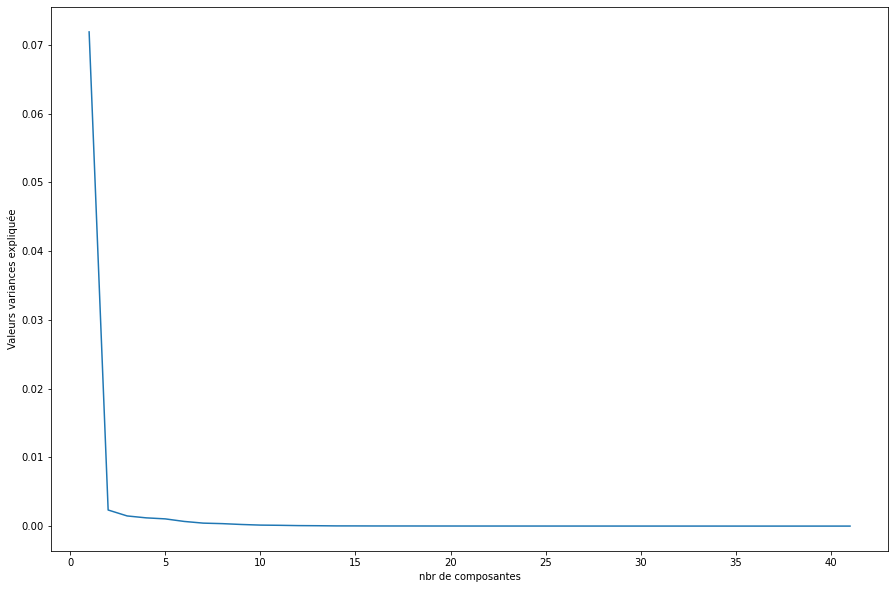

In [286]:
# variance expliquée en fonction du nombre de composante : graphique : 
plt.figure(figsize = (15,10))
plt.plot(np.arange(1,42), pca.explained_variance_)
plt.xlabel('nbr de composantes')
plt.ylabel('Valeurs variances expliquée')
plt.show()

# on note une cassure , un coude à partir pour 2 composantes. Ceci est assez cool en vue de la mise en place de Kmeans

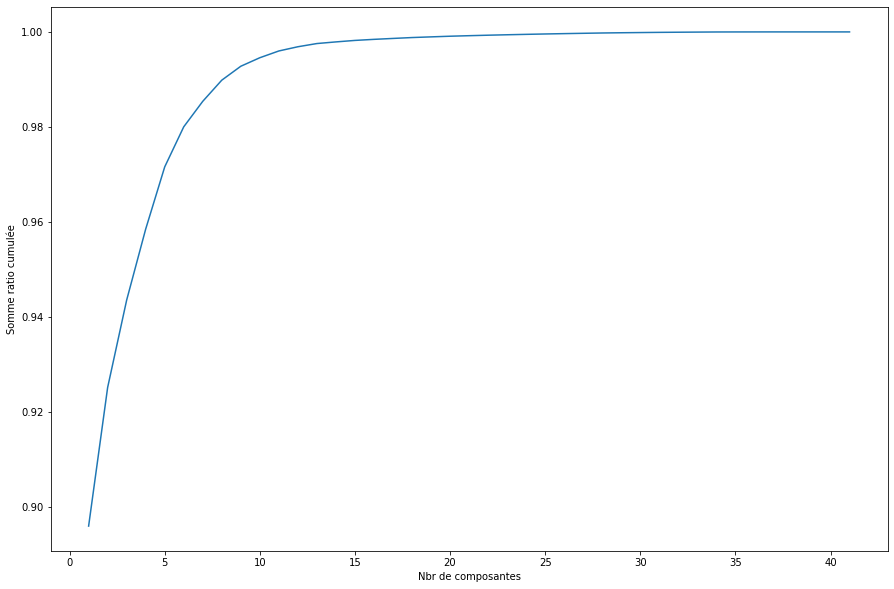

In [163]:
# on vérifie avec la somme cumulée du ratio de la varianlce expliquée en fonction du nombre de composantes

# calcu des ratios : 
len(pca.explained_variance_ratio_)

# graph de la somme cumulée des ratios en fonction du nbr de composantes

plt.figure(figsize =(15,10))
plt.plot(np.arange(1,42), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Nbr de composantes')
plt.ylabel('Somme ratio cumulée')
plt.show()

In [ ]:
# pour 2 axes, la variance expliquée est de plus de 92%

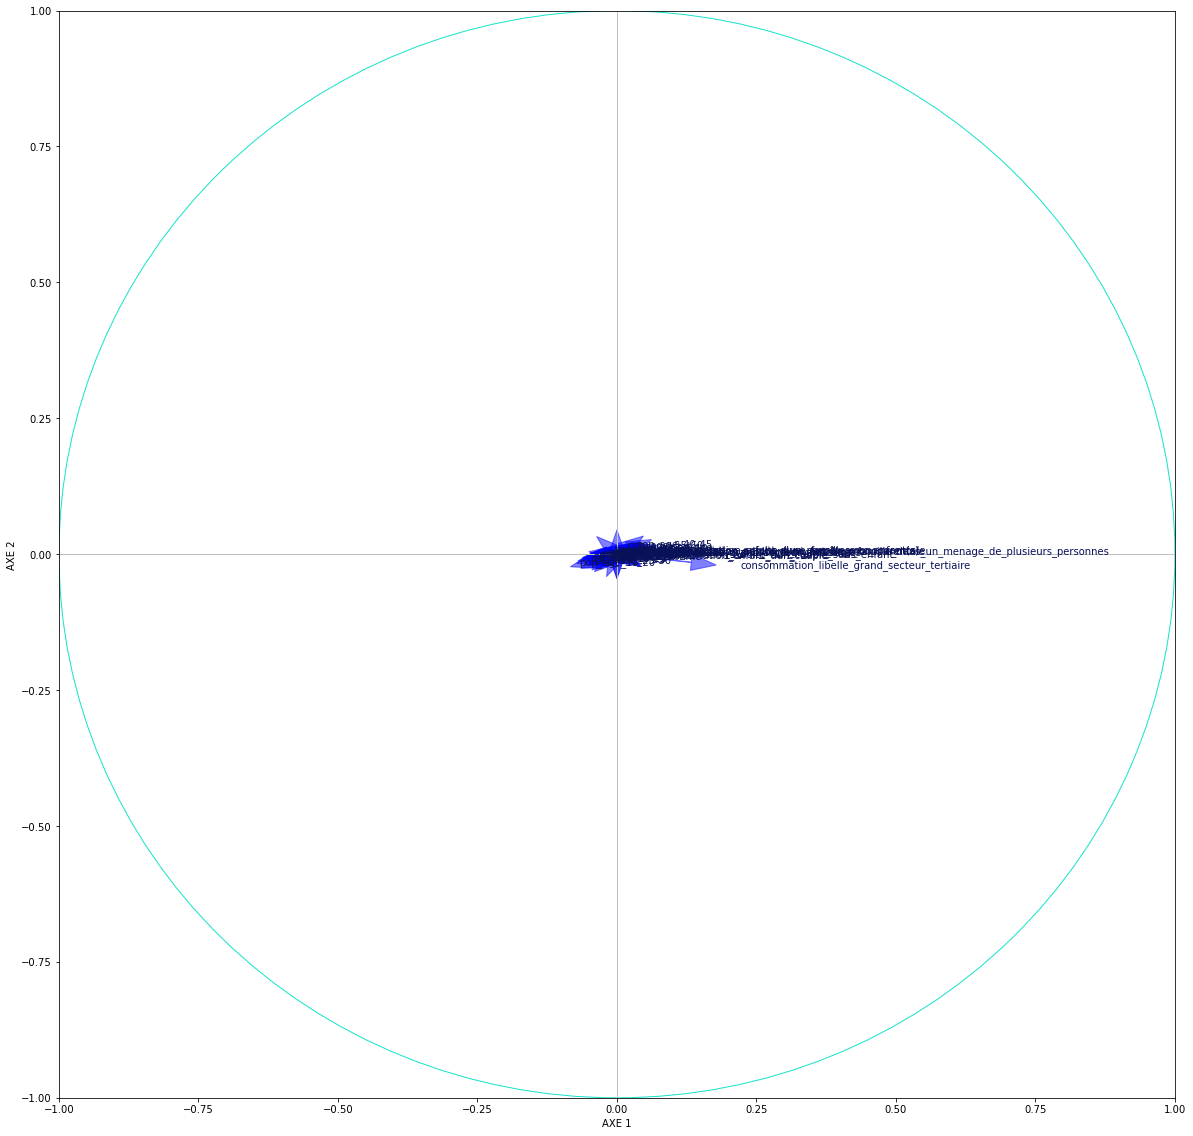

In [164]:
# Cercle des corrélations (évaluer l'influence de chaque variable pour chacun des 2 axes)

racine_valeurs_propres = np.sqrt(pca.explained_variance_)
corvar = np.zeros((41, 41))
for k in range(41):
    corvar[:, k] = pca.components_[:, k] * racine_valeurs_propres[k]

# Délimitation de la figure
fig, axes = plt.subplots(figsize=(20, 20))
# plt.figure(figsize = (20,20))
axes.set_xlim(-1, 1)
axes.set_ylim(-1, 1)
# plt.xlim(-1,1)
# plt.ylim(-1,1)

# Affichage des variables
for j in range(41):
    plt.annotate(df_lyon_num.columns[j], (corvar[j, 0], corvar[j, 1]), color='#091158')
    plt.arrow(0, 0, corvar[j, 0]*0.6, corvar[j, 1]*0.6, alpha=0.5, head_width=0.03, color='b')

# Ajout des axes
plt.plot([-1, 1], [0, 0], color='silver', linestyle='-', linewidth=1)
plt.plot([0, 0], [-1, 1], color='silver', linestyle='-', linewidth=1)

# Cercle et légendes

cercle = plt.Circle((0, 0), 1, color='#16E4CA', fill=False)
axes.add_artist(cercle)
plt.xlabel('AXE 1')
plt.ylabel('AXE 2')
plt.show()

# question pour Paul - comment agrandir ce cercle c'est illisible 

In [ ]:
### 4.1 - Corrélation des 2 composantes principales avec les autres variables

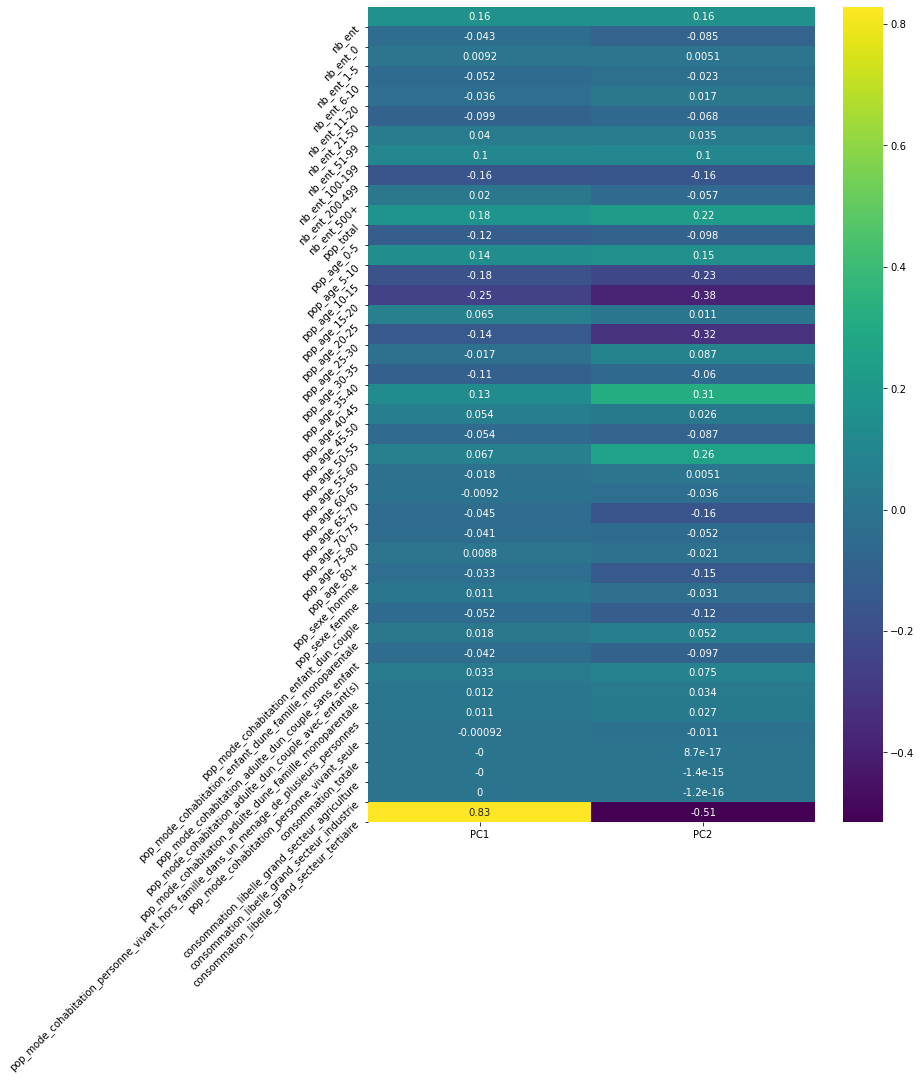

In [194]:
# Afficher les coeficients de corrélations de chaque variables
# avec les deux premières variables  = (les 2 premiers axes)
# grâce à l'attribut components_ de pca

Comp_PCA = pd.DataFrame({'PC1': pca.components_[:, 0], 'PC2': pca.components_[:, 1]})

plt.figure(figsize=(10, 15))

sns.heatmap(Comp_PCA, annot=True, cmap='viridis')
plt.yticks(np.arange(1,42), df_lyon_num.columns, rotation = 45)
plt.show()


(1413, 6)


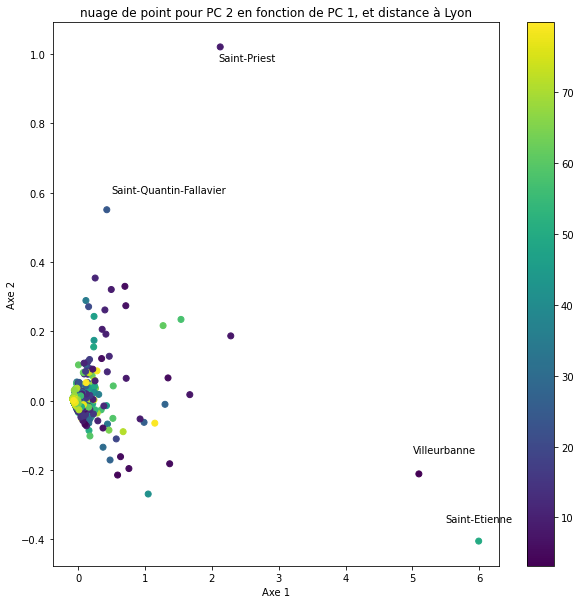

In [296]:
# affichage graphique en nuage des points pour les deux composantes PC1 et PC2
# créer un DataFrame pca_lyon_distance avec les coordonnées des 2 axes principaux et la distance à Lyon

distance_lyon = df_lyon['distance_to_Lyon']
distance_lyon
nom_commune = df_lyon['nom_commune']
latitude = df_lyon['latitude']
longitude = df_lyon['longitude']

pca_lyon_distance = pd.DataFrame({'Axe 1': coord[:,0], 'Axe 2' : coord[:,1], 
                                  'distance_to_Lyon' : distance_lyon,
                                 'nom_commune' : nom_commune,
                                 'latitude' : latitude,
                                 'longitude' : longitude})
pca_lyon_distance.head()
print(pca_lyon_distance.shape)

plt.figure(figsize = (10,10))

plt.scatter(pca_lyon_distance['Axe 1'], pca_lyon_distance['Axe 2'],
           c = pca_lyon_distance['distance_to_Lyon']
           )
plt.xlabel('Axe 1')
plt.ylabel('Axe 2')
plt.title('nuage de point pour PC 2 en fonction de PC 1, et distance à Lyon')
plt.annotate("Saint-Etienne", xy = (5.990848,-0.405483 ), xytext = (5.5, -0.35))
plt.annotate("Villeurbanne", xy = (5.096273,-0.211655), xytext = (5, -0.15))
plt.annotate("Saint-Quantin-Fallavier", xy = (0.428808,0.550380), xytext = (0.5,0.6))
plt.annotate("Saint-Priest", xy = (2.125354,1.020063), xytext = (2.1, 0.98))
plt.colorbar()
plt.show()



In [ ]:
# Quelles sont les villes représentées aux points extrêmes et pourquoi ?  

In [168]:
pca_lyon_distance.loc[pca_lyon_distance['Axe 1']>5]


,Axe 1,Axe 2,distance_to_Lyon,nom_commune
14197,5.990848,-0.405483,49.646994,Saint-Etienne
24788,5.096273,-0.211655,3.180791,Villeurbanne


In [169]:
pca_lyon_distance.loc[pca_lyon_distance['Axe 2']>0.5]
# la commune en haut avec une valeur Axe 2 > 15 est Saint-Priest située à 9 km de Lyon (je ne comprends pas les bins)

,Axe 1,Axe 2,distance_to_Lyon,nom_commune
12901,0.428808,0.550380,24.434461,Saint-Quentin-Fallavier
24743,2.125354,1.020063,9.159015,Saint-Priest


In [ ]:
# essayons de comprendre pourquoi ces  4 villes sont excentrées du nuage de points

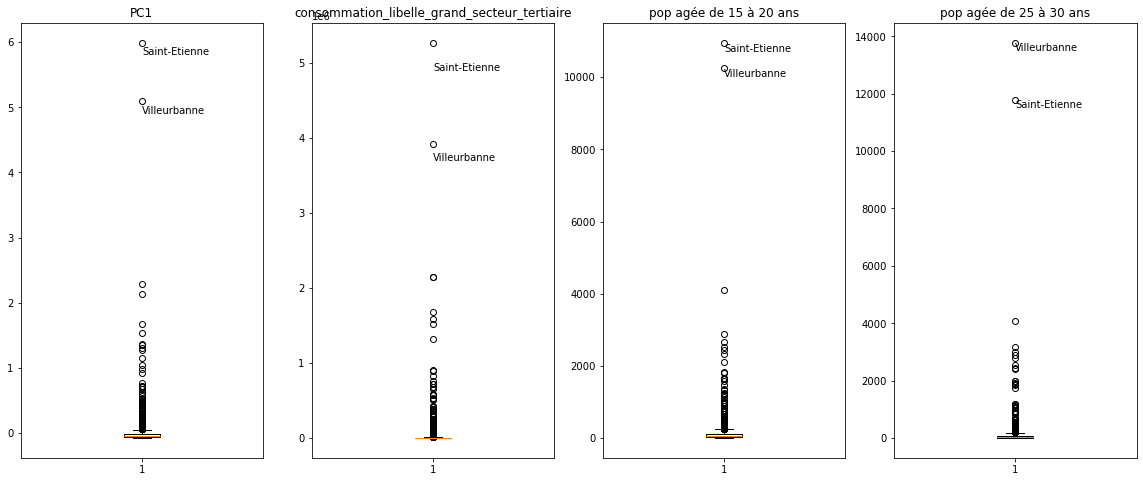

In [310]:
# regardons la distribution pour les 3 variables les plus corrélées avec la Composantes principales Axe 1 
# soit Consommation de secteur tertiaire ; population agée de 15 à 20 ans  ; population agée de 25 à 30 ans 

plt.figure(figsize = (20,8))


plt.subplot(141)
plt.boxplot(pca_lyon_kmeans_2PC['Axe 1'])
plt.title('PC1')
plt.annotate("Saint-Etienne", xy = (1, 5.9900848), xytext = (1, 5.8))
plt.annotate("Villeurbanne", xy = (1, 5.096273), xytext = (1,4.9))


plt.subplot(142)
plt.boxplot(df_lyon.consommation_libelle_grand_secteur_tertiaire)
plt.title('consommation_libelle_grand_secteur_tertiaire')
plt.annotate("Saint-Etienne", xy = (1, 5.267797e+06), xytext = (1, 4.9e+06))
plt.annotate("Villeurbanne", xy = (1, 3.921854e+06), xytext = (1,3.7e+06))


plt.subplot(143)
plt.boxplot(df_lyon['pop_age_15-20'])
plt.title('pop agée de 15 à 20 ans')
plt.annotate("Saint-Etienne", xy = (1, 10957), xytext = (1, 10700))
plt.annotate("Villeurbanne", xy = (1, 10253), xytext = (1,10000))

plt.subplot(144)
plt.boxplot(df_lyon['pop_age_25-30'])
plt.title('pop agée de 25 à 30 ans')
plt.annotate("Saint-Etienne", xy = (1, 11793), xytext = (1, 11500))
plt.annotate("Villeurbanne", xy = (1, 13776), xytext = (1,13500))

plt.show()

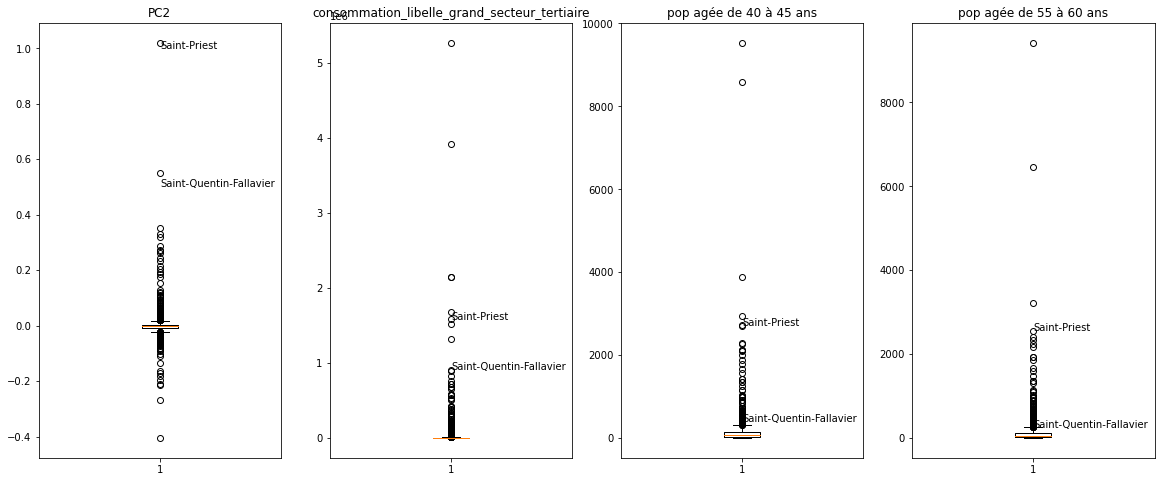

In [314]:
# regardons la distribution pour les 3 variables les plus corrélées avec la Composantes principales Axe 1 et Axe 2 
# soit Consommation de secteur tertiaire ; population agée de 15 à 20 ans  ; population agée de 25 à 30 ans 

plt.figure(figsize = (20,8))


plt.subplot(141)
plt.boxplot(pca_lyon_kmeans_2PC['Axe 2'])
plt.title('PC2')
plt.annotate("Saint-Priest", xy = (1, 1.020063), xytext = (1, 1))
plt.annotate("Saint-Quentin-Fallavier", xy = (1, 0.550380), xytext = (1, 0.5))


plt.subplot(142)
plt.boxplot(df_lyon.[consommation_libelle_grand_secteur_tertiaire])
plt.title('consommation_libelle_grand_secteur_tertiaire')
plt.annotate("Saint-Priest", xy = (1, 1.591895e+06), xytext = (1, 1.58e+06))
plt.annotate("Saint-Quentin-Fallavier", xy = (1, 909581.778244), xytext = (1,909500))


plt.subplot(143)
plt.boxplot(df_lyon['pop_age_40-45'])
plt.title('pop agée de 40 à 45 ans')
plt.annotate("Saint-Priest", xy = (1, 2722), xytext = (1, 2710))
plt.annotate("Saint-Quentin-Fallavier", xy = (1, 386), xytext = (1,385))

plt.subplot(144)
plt.boxplot(df_lyon['pop_age_55-60'])
plt.title('pop agée de 55 à 60 ans')
plt.annotate("Saint-Priest", xy = (1, 2554), xytext = (1, 2550))
plt.annotate("Saint-Quentin-Fallavier", xy = (1, 249), xytext = (1,245))

plt.show()

In [313]:
df_lyon_variables_corr_PC1 = df_lyon[['nom_commune', 'consommation_libelle_grand_secteur_tertiaire', 'pop_age_15-20', 'pop_age_25-30', 'pop_age_40-45', 'pop_age_55-60']]
df_lyon_variables_corr_PC1.loc[df_lyon_variables_corr_PC1['nom_commune']== 'Saint-Quentin-Fallavier']

,nom_commune,consommation_libelle_grand_secteur_tertiaire,pop_age_15-20,pop_age_25-30,pop_age_40-45,pop_age_55-60
12901,Saint-Quentin-Fallavier,909581.778244,374.0,311.0,386.0,249.0


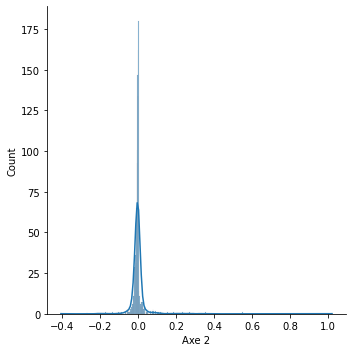

In [347]:
sns.displot(pca_lyon_kmeans_2PC['Axe 2'], kde = True)

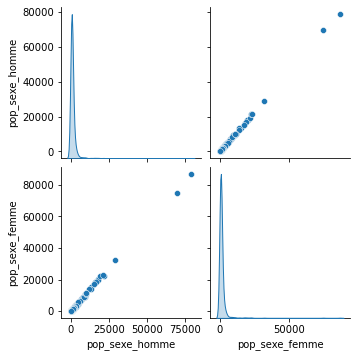

In [353]:
sns.pairplot(df_lyon_num.iloc[:,28:30], diag_kind = 'kde')

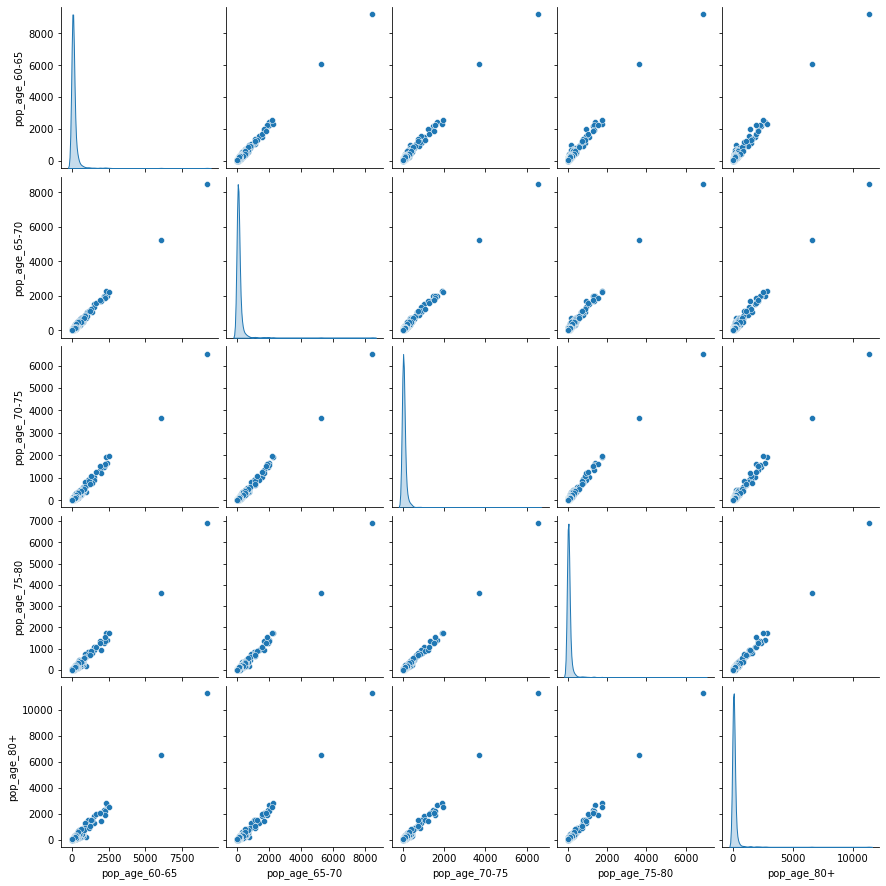

In [354]:
sns.pairplot(df_lyon_num.iloc[:,23:28], diag_kind = 'kde')

In [ ]:
# représentation des Composantes Principales en fonction des coordonnées géographiques de chaque communes

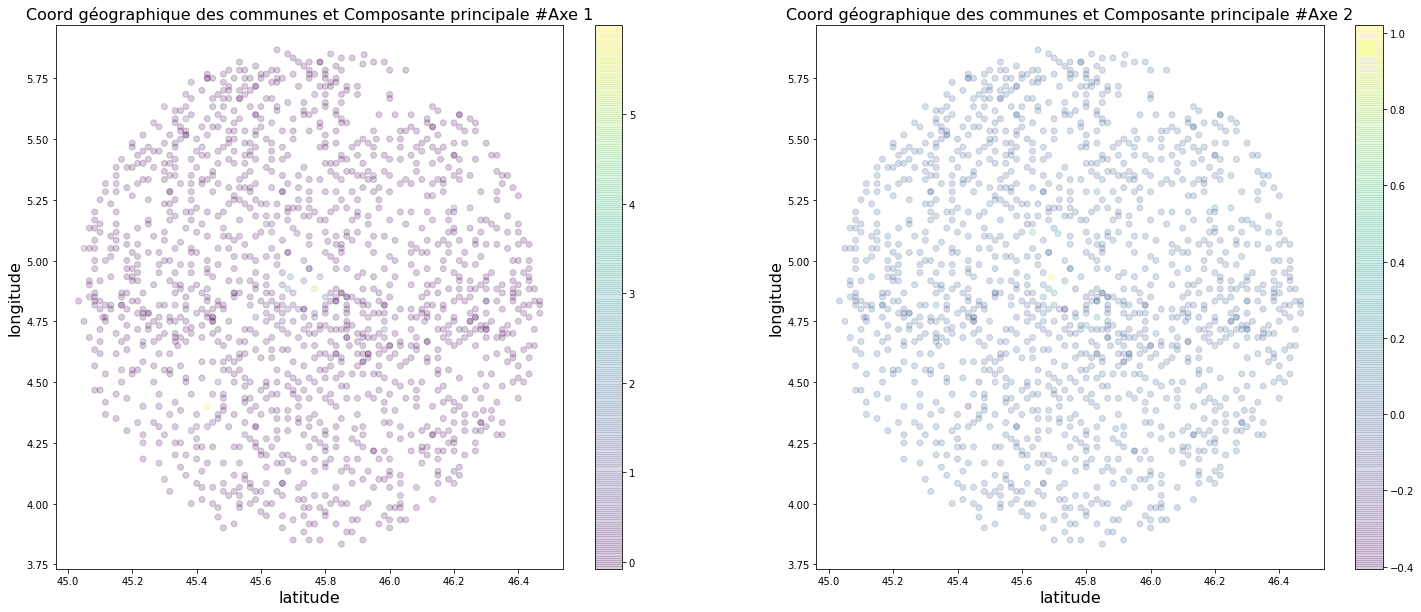

In [355]:

plt.figure(figsize = (25,10))
plt.subplot(121)  
plt.scatter(
    pca_lyon_distance['latitude'],
    pca_lyon_distance['longitude'],
    c=pca_lyon_distance['Axe 1'],
    alpha = 0.2
)

# plt.xlim(0,3)
# plt.ylim(-0.5,0.5)
plt.xlabel('latitude', fontsize = 16)
plt.ylabel('longitude', fontsize = 16)
plt.title('Coord géographique des communes et Composante principale #Axe 1', fontsize = 16)

plt.colorbar()

plt.subplot(122)
plt.scatter(
    pca_lyon_distance['latitude'],
    pca_lyon_distance['longitude'],
    c=pca_lyon_distance['Axe 2'],
    alpha = 0.2
)

# plt.xlim(0,3)
# plt.ylim(-0.5,0.5)
plt.xlabel('latitude', fontsize = 16)
plt.ylabel('longitude', fontsize = 16)
plt.title('Coord géographique des communes et Composante principale #Axe 2', fontsize = 16)

plt.colorbar()
plt.show()



In [ ]:
### 4.2 K-Means avec 2 composantes principales et en essayant avec n_clusters = 3

In [288]:
# mise en oeuvre de K-means à partir des 2 composantes principale , Comp_PCA
pca_lyon_kmeans_2PC = pd.DataFrame({'Axe 1': coord[:,0], 'Axe 2' : coord[:,1]})
print(pca_lyon_kmeans.shape)


(1413, 10)


In [320]:
# instanciation de kmeans - essai avec 3 clusters
kmeans_2PC = KMeans(n_clusters = 3)


# entrainement sur Comp_PCA
kmeans_2PC.fit(pca_lyon_kmeans_2PC)

# Prédictions
y_kmeans_2PC = kmeans_2PC.predict(pca_lyon_kmeans_2PC)
print(y_kmeans_2PC)

# coordonnées des centres des clusters
kmeans_2PC.cluster_centers_

x_cluster_centers = kmeans_2PC.cluster_centers_[:,0]
y_cluster_centers = kmeans_2PC.cluster_centers_[:,1]

print(x_cluster_centers)
print(y_cluster_centers)

print("la valeur de l'inertie por le modèle est : ", kmeans_2PC.inertia_)
print(len(y_kmeans_2PC))

[0 0 0 ... 0 0 0]
[-0.02318521  5.54356052  1.17832647]
[-0.00049973 -0.30856938  0.0729591 ]
la valeur de l'inertie por le modèle est :  17.33977779306452
1413


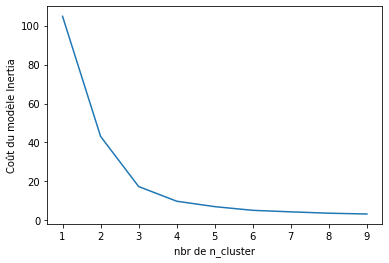

In [292]:
# choix du nombre de clusters optimal 

L = []
for i in range (1,10):
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(pca_lyon_kmeans_2PC)
    L.append(kmeans.inertia_)

plt.plot(range(1,10), L)
plt.xlabel('nbr de n_cluster')
plt.ylabel('Coût du modèle Inertia')
plt.show()


In [ ]:
# on a un coude à n-clusters = 2 et n_clusters = 3

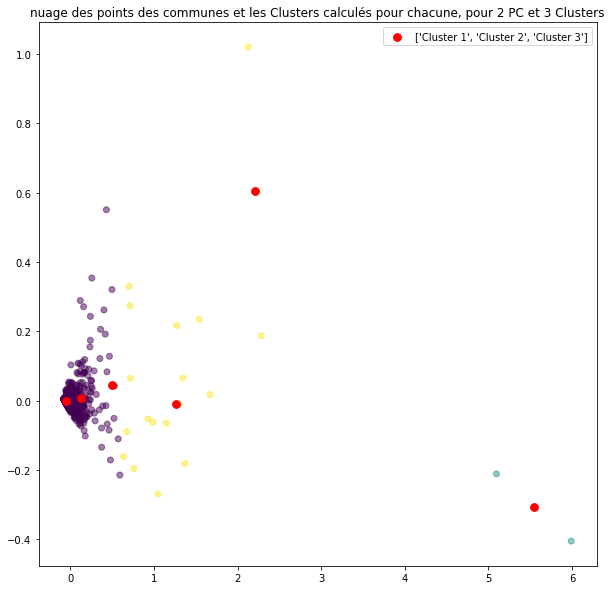

In [359]:
# représentation graphique
plt.figure(figsize = (10,10))
plt.scatter(pca_lyon_kmeans_2PC['Axe 1'], pca_lyon_kmeans_2PC['Axe 2'],alpha = 0.5, c = y_kmeans_2PC)
plt.scatter(x_cluster_centers, y_cluster_centers, c = 'red', s = 60,label = ['Cluster 1', 'Cluster 2', 'Cluster 3'])
plt.title("nuage des points des communes et les Clusters calculés pour chacune, pour 2 PC et 3 Clusters")
plt.legend()
plt.show()

In [ ]:
# A priori o peut affiner - on va faire varier le nombre de variables (Composantes Principales) et le nombre de Cluster

## 4 - Mise en oeuvre de Kmeans pour créer un nombres adaptés de Clusters
### Option avec le résultat de PCA et sans PCA

In [431]:
n_variable = 10
n_cluster = 5

In [432]:
# mise en oeuvre de K-means à partir des 2 composantes principale , Comp_PCA
# pca_lyon_kmeans = pd.DataFrame({'Axe 1': coord[:,0], 'Axe 2' : coord[:,1]})
# print(pca_lyon_kmeans.shape)

pca_lyon_kmeans = pd.DataFrame({"Axe " + str(i + 1): coord[:,i] for i in range(n_variable)})

# instanciation de kmeans - essai avec 3 clusters
# kmeans = KMeans(n_clusters = 3)
kmeans = KMeans(n_clusters = n_cluster)

# entrainement sur Comp_PCA
kmeans.fit(pca_lyon_kmeans)

# Prédictions
y_kmeans = kmeans.predict(pca_lyon_kmeans)
print(len(y_kmeans))

# coordonnées des centres des clusters
kmeans.cluster_centers_

x_cluster_centers = kmeans.cluster_centers_[:,0]
y_cluster_centers = kmeans.cluster_centers_[:,1]

print(x_cluster_centers)
print(y_cluster_centers)

print("la valeur de l'inertie por le modèle est : ", kmeans.inertia_)
print(len(y_kmeans))


1413
[-0.04850575  5.54356052  0.55887341  1.56097685  0.12624109]
[-0.00235596 -0.30856938  0.02290024  0.1644612   0.0093526 ]
la valeur de l'inertie por le modèle est :  14.091793039600772
1413


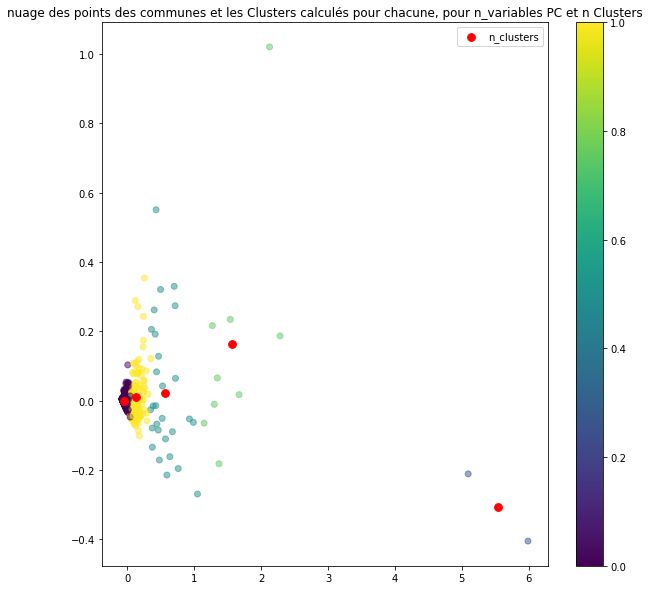

In [433]:
# représentation graphique
plt.figure(figsize = (10,10))
plt.scatter(pca_lyon_kmeans['Axe 1'], pca_lyon_kmeans['Axe 2'], alpha = 0.5, c = y_kmeans)
plt.scatter(x_cluster_centers, y_cluster_centers, c = 'red', s = 60, label = 'n_clusters')
plt.title("nuage des points des communes et les Clusters calculés pour chacune, pour n_variables PC et n Clusters")
plt.legend()
plt.colorbar()

plt.show()

In [272]:
coord.shape


(1413, 41)

In [ ]:
# on est bien avec 3 clusters, peut-on améliorer ?  peut-être en introduisant de nouveles variables
# nouvelles lignes 
nb_ent = df_lyon_num['nb_ent']

for col in df.columns:
    if 'nb_ent_' in col:  # si nb_ent qui est dans le nom de la colonne, alors on divise la valeur de nb_ent_0 par nb_ent
        df[col] = df[col] / df['nb_ent']
        
        # répliquer pour pop_total et pop_age_
        # répliquer pour pop et pop_mode_cohabitation
        # supprimer nbr de points total
        # idem avec conso

## 5 - Intégration du Cluster déterminé pour chaque commune, et positionnement sur une carte pour visualiser comment les clusters sont répartis géographiquement 
# TO DO

In [434]:
pca_lyon_distance_kmeans = pd.DataFrame({
                                  'distance_to_Lyon' : distance_lyon,
                                 'nom_commune' : nom_commune,
                                 'latitude' : latitude,
                                 'longitude' : longitude,
                                 'cluster' : y_kmeans})

pca_lyon_distance_kmeans.loc[pca_lyon_distance_kmeans['nom_commune'] == 'Villeurbanne']

,distance_to_Lyon,nom_commune,latitude,longitude,cluster
24788,3.180791,Villeurbanne,45.766667,4.883333,1


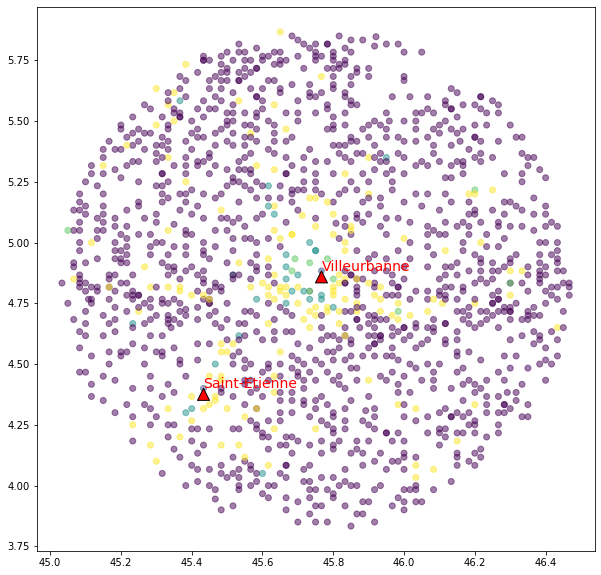

In [435]:
plt.figure(figsize = (10,10))
plt.scatter(x = pca_lyon_distance_kmeans['latitude'],
            y = pca_lyon_distance_kmeans['longitude'],
           c = pca_lyon_distance_kmeans['cluster'],
            alpha = 0.5
           )
plt.annotate("Saint-Etienne", xy = (45.433333, 4.4), xytext =(45.433333, 4.4), c = 'red', fontsize = 14, 
             arrowprops = {'facecolor' : 'red'} )
plt.annotate('Villeurbanne', xy = (45.766667, 4.88333), xytext = (45.766667, 4.88333),c = 'red', fontsize = 14 ,
            arrowprops = {'facecolor' : 'red'})
plt.show()

In [436]:
kmeans.score(pca_lyon_kmeans)

-14.091793039600772

In [ ]:
# essayer avec plus de cluster même jdd

# pour streamlit penser à une appli qui permettra de choisir parmis une liste de communes en France et une cellule
# de choix de la distance à la commune

In [437]:
pip install folium


Could not fetch URL https://pypi.org/simple/pip/: There was a problem confirming the ssl certificate: HTTPSConnectionPool(host='pypi.org', port=443): Max retries exceeded with url: /simple/pip/ (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1123)'))) - skipping


In [440]:
import folium
from folium.plugins import FastMarkerCluster



my_map_cluster = folium.Map(location = [45.750000, 4.850000], tiles='OpenStreetMap', zoom_start = 10)
folium.Marker(location =[45.750000, 4.850000] ).add_to(my_map_cluster)

def add_marker(row):
    if row['cluster']==0:
        marker = folium.CircleMarker([row['latitude'], row['longitude']], radius =2 , 
                color = 'purple', alpha = 0.4, popup = row['cluster'])
        marker.add_to(my_map_cluster)
        
    elif row['cluster'] == 1:
        marker = folium.CircleMarker([row['latitude'], row['longitude']], radius =7 , 
                color = 'mediumblue',  popup = row['cluster'])
        marker.add_to(my_map_cluster)
        
    elif row['cluster'] == 2:
        marker = folium.CircleMarker([row['latitude'], row['longitude']], radius =7 , 
                color = 'lime',  popup = row['cluster'])
        marker.add_to(my_map_cluster)
        
    elif row['cluster'] == 3:
        marker = folium.CircleMarker([row['latitude'], row['longitude']], radius =7 , 
                color = 'darkolivegreen',  popup = row['cluster'])
        marker.add_to(my_map_cluster)
        
#     elif row['cluster'] == 4:
#         marker = folium.CircleMarker([row['latitude'], row['longitude']], radius =5 , 
#                 color = 'lime',  popup = row['cluster'])
#         marker.add_to(my_map_cluster)
        
    else:
        marker = folium.CircleMarker([row['latitude'], row['longitude']], radius =5, 
                color = 'orange',  popup = row['cluster'])
        marker.add_to(my_map_cluster)
        
        
pca_lyon_distance_kmeans.apply(add_marker, axis = 1)
        
    

my_map_cluster
